In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report


data = pd.read_csv('data\\br2000_mrf.csv')


def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,2,1,3,0,0,1,0,0,6,1,5,0
1,0,1,1,0,7,0,0,1,0,0,6,1,7,1
2,1,1,2,1,6,0,0,1,0,3,4,1,8,1
3,0,0,1,0,7,1,0,1,0,0,4,1,6,0
4,0,0,6,0,1,1,0,0,0,1,8,1,2,0


In [2]:
#generate Phase 1

def generate(df, numTuples=None, numClass=None, epsilon=1.0):
    print(df.shape)
    #optionale parameter abklären
    if numTuples is None:
        numTuples = df.shape[0]
    if numClass is None:
        numClass = df.shape[1] - 1

    className = df.columns[numClass]
    attributesName = [col for col in df.columns if col != className]

    numHistograms = df.shape[1] - 1
    epsilon_per_hist = epsilon/numHistograms

    histograms = {} # Dict für jedes Marginal nach Attribut sortiert
    for attributeName in attributesName:
        counts = df[[attributeName, className]].value_counts() # Series mit MultiIndex, Ebene 0 = Attribut, Ebene 1 = Klasse
        noisy_counts = laplace_mech(counts, 1, epsilon_per_hist)
        noisy_counts.clip(lower=0.0, inplace=True) # Entfernen von negativen Werten
        #noisy_counts = noisy_counts.round()
        histograms[attributeName] = noisy_counts

    print(histograms["1"])

generate(data)


(38000, 14)
1  13
0  0     20366.355301
1  0      6240.355301
   1      5173.355301
0  1      3390.355301
2  1      1592.355301
   0       807.355301
3  1       277.355301
   0       120.355301
4  1        83.355301
   0        42.355301
5  1        27.355301
6  1        18.355301
5  0        17.355301
6  0        16.355301
Name: count, dtype: float64


In [3]:
#generate Phase 2
def generate(df, numTuples=None, numClass=None, epsilon=1.0):
    print(df.shape)
    #optionale parameter abklären
    if numTuples is None:
        numTuples = df.shape[0]
    if numClass is None:
        numClass = df.shape[1] - 1

    className = df.columns[numClass]
    attributesName = [col for col in df.columns if col != className]
    numHistograms = df.shape[1] - 1
    epsilon_per_hist = epsilon/numHistograms
    histograms = {}
    for attributeName in attributesName:
        counts = df[[attributeName, className]].value_counts()
        noisy_counts = laplace_mech(counts, 1, epsilon_per_hist)
        noisy_counts.clip(lower=0.0, inplace=True)
        #noisy_counts = noisy_counts.round()
        histograms[attributeName] = noisy_counts
# bis hier Phase 1

    classTotals = {}
    for attr_name, hist in histograms.items(): #key-value für das Histogramm-Dict sind Attributname und das dazugehörige Histogramm
        for (attr_val, class_val), count in hist.items(): # key-value für die Histogramme selbst sind der multiIndex und die Counts
            if class_val not in classTotals:
                classTotals[class_val] = 0.0 # Eintrag erstellen, falls die Klasse noch nicht in classTotals angelegt wurde
            classTotals[class_val] += count

    total = sum(classTotals.values())
    p = {c: classTotals[c] / total for c in classTotals} # Key: Klasse, Value: P(Klasse)

    classTuples = {c: round(numTuples * p[c]) for c in classTotals} # Die Längen der Vektoren ist NumTuples * P(c=c_1)

    class_vector = {c: [c] * classTuples[c] for c in classTuples } # Füllen Sie die Vektoren mit den zugehörigen c Werten.

    cond_attr = {} # Dict für P(attr | class)

    for attr_name, hist in histograms.items():   # pro Attribut
        cond_attr[attr_name] = {}   # pro Attribut ein verschachteltes Dict
        for c in classTotals:                    # pro Klasse
            attr_counts = {}                     # neu für (attr, class)
            for (attr_val, class_val), count in hist.items(): # pro Histogramm
                if class_val == c:
                    attr_counts[attr_val] = attr_counts.get(attr_val, 0) + count # wenn Eintrag existiert, wird der bisherige Count verwendet, wenn nicht, dann 0.

            sum_c = sum(attr_counts.values())

            if sum_c == 0:
            # gleichverteilte Notlösung
                if attr_counts: #Info über Klassen da, aber alle counts auf 0
                    gleich = 1.0 / len(attr_counts)
                    probs = {a: gleich for a in attr_counts}
                else: # gar keine Werte – dann kannst du z.B. später skippen
                    probs = {}
            else:
                probs = {a: attr_counts[a] / sum_c for a in attr_counts}
            cond_attr[attr_name][c] = probs

    attr_vectors = {} #MultiIndex, Attribut und Klasse, Value ist Vektor
    for attr_name, class_dict in cond_attr.items():
        attr_vectors[attr_name] = {}
        for c,probs in class_dict.items():
            n_c = classTuples[c]
            target_count = {}

            for attr_val, p_val in probs.items():
                target_count[attr_val] = round(p_val * n_c)

            attr_vec_c = [] # vektor pro klasse, mit Länge n_c, und values sind die attributwerte verteilt nach vorhin berechneten Ps
            for attr_val, cnt in target_count.items():
                attr_vec_c.extend([attr_val] * cnt)

            # LÄNGE ANPASSEN!
            n_c = classTuples[c]
            current_len = len(attr_vec_c)
            diff = n_c - current_len

            if diff > 0:
                vals = list(probs.keys())
                extra = np.random.choice(vals, size=diff, p=list(probs.values()))
                attr_vec_c.extend(extra)

            elif diff < 0:
                remove_indices = np.random.choice(len(attr_vec_c), size=-diff, replace=False)
                for idx in sorted(remove_indices, reverse=True):
                    attr_vec_c.pop(idx)

            np.random.shuffle(attr_vec_c) # Mischen des Vektors in-place, evtl Datenleck (ohne shuffle Accuracy=1)

            attr_vectors[attr_name][c] = attr_vec_c

    blocks = {}
    for c in classTuples:
        n_c = classTuples[c]
        block = {}

        for attributeName in attributesName:
            values = attr_vectors[attributeName][c] # Vektoren für jedes Attribut + aktuelle Klasse
            #sanity check?
            block[attributeName] = values
        block[className] = class_vector[c]  # Vektor für die Klasse selbst
        blocks[c] = block # Klassenvektor + einer pro Attribut für die aktuelle Klasse werden zu Blocks hinzugefügt.

    df_blocks = {c: pd.DataFrame(block) for c, block in blocks.items()} # ein DataFrame pro Klasse
    synthetic_df = pd.concat(df_blocks.values(), ignore_index=True) # Zusammenfügen der Klassen-DataFrames

    #print("original:", df.shape)
    #print("synthetic:", synthetic_df.shape)

    synthetic_df = synthetic_df.sample(frac=1, random_state=42).reset_index(drop=True) #shuffling


    #print(classTotals)
    #print(p)
    #print(classTuples)
    #print(cond_attr)
    #print(attr_vectors['13']['<=50K'])

    return synthetic_df

synthetic_data = generate(data)

(38000, 14)


In [4]:
#GPT Zelle
def build_pipeline(clf=None):
    """
    Baut eine sklearn-Pipeline:
    - OneHotEncoding für alle Feature-Spalten (alle außer der letzten)
    - Classifier (default: RandomForest, kann aber übergeben werden)
    """
    if clf is None:
        clf = RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )

    # Alle Spalten außer der letzten sind Features
    # (funktioniert auch mit '0', '1', ..., '13' als Spaltennamen)
    def make_preprocessor(df):
        feature_cols = df.columns[:-1]
        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols)
            ]
        )
        return preprocessor

    # kleine Wrapperfunktion, damit wir df nicht global brauchen
    def make_model(df):
        preprocessor = make_preprocessor(df)
        model = Pipeline(steps=[
            ("prep", preprocessor),
            ("clf", clf)
        ])
        return model

    return make_model


def evaluate_df(df, clf=None, n_splits=10, test_size=0.2, base_random_state=0):
    """
    - df: DataFrame mit letzter Spalte = Klasse
    - clf: optionaler Classifier (sonst RandomForest)
    - n_splits: wie viele verschiedene Train/Test-Splits (mit unterschiedlichen seeds)
    - test_size: Anteil Testdaten
    """
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    make_model = build_pipeline(clf)

    accuracies = []
    confusion_matrices = []

    classes = np.unique(y)

    for i in range(n_splits):
        rs = base_random_state + i
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=rs,
            stratify=y  # damit Klassenverteilung im Split erhalten bleibt
        )

        model = make_model(df)   # baut Pipeline mit passenden Spalten
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = (y_pred == y_test).mean()
        accuracies.append(acc)

        cm = confusion_matrix(y_test, y_pred, labels=classes)
        confusion_matrices.append(cm)

    return {
        "classes": classes,
        "accuracies": np.array(accuracies),
        "confusion_matrices": confusion_matrices,
    }


In [5]:
# Synthetische Daten
synthetic_data = generate(data)
synth_results = evaluate_df(synthetic_data, n_splits=10)

# Originaldaten (data) aus CSV
orig_results = evaluate_df(data, n_splits=10)

print("Originaldaten:")
print("  Accuracy mean:", orig_results["accuracies"].mean())
print("  Accuracy std :", orig_results["accuracies"].std())
print("  Confusion Matrix (Split 0):")
print(orig_results["confusion_matrices"][0])
print("  Klassenreihenfolge:", orig_results["classes"])

print("\nSynthetische Daten:")
print("  Accuracy mean:", synth_results["accuracies"].mean())
print("  Accuracy std :", synth_results["accuracies"].std())
print("  Confusion Matrix (Split 0):")
print(synth_results["confusion_matrices"][0])
print("  Klassenreihenfolge:", synth_results["classes"])

synthetic_data.head()

(38000, 14)
Originaldaten:
  Accuracy mean: 0.8010131578947368
  Accuracy std : 0.003641695481967089
  Confusion Matrix (Split 0):
[[4964  541]
 [ 938 1157]]
  Klassenreihenfolge: [0 1]

Synthetische Daten:
  Accuracy mean: 0.8207894736842105
  Accuracy std : 0.00368138989770812
  Confusion Matrix (Split 0):
[[5069  436]
 [ 915 1180]]
  Klassenreihenfolge: [0 1]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,2,4,2,2,0,0,1,0,3,3,1,5,1
1,0,0,2,0,1,1,0,1,0,0,4,1,1,0
2,0,1,3,0,2,0,0,0,0,0,4,1,9,0
3,0,1,5,3,2,0,1,0,0,0,5,1,9,0
4,0,1,5,0,4,0,0,1,0,0,4,1,0,0


In [6]:
#version mit alternativem clf
from sklearn.tree import DecisionTreeClassifier

# Synthetische Daten
clf = DecisionTreeClassifier(random_state=42)
synthetic_data = generate(data)   # deine Funktion
synth_results = evaluate_df(synthetic_data, clf=clf, n_splits=10)

# Originaldaten (data) aus CSV
orig_results = evaluate_df(data, clf=clf, n_splits=10)

print("Originaldaten:")
print("  Accuracy mean:", orig_results["accuracies"].mean())
print("  Accuracy std :", orig_results["accuracies"].std())
print("  Confusion Matrix (Split 0):")
print(orig_results["confusion_matrices"][0])
print("  Klassenreihenfolge:", orig_results["classes"])

print("\nSynthetische Daten:")
print("  Accuracy mean:", synth_results["accuracies"].mean())
print("  Accuracy std :", synth_results["accuracies"].std())
print("  Confusion Matrix (Split 0):")
print(synth_results["confusion_matrices"][0])
print("  Klassenreihenfolge:", synth_results["classes"])

(38000, 14)
Originaldaten:
  Accuracy mean: 0.7616315789473684
  Accuracy std : 0.004743124488867803
  Confusion Matrix (Split 0):
[[4716  789]
 [1015 1080]]
  Klassenreihenfolge: [0 1]

Synthetische Daten:
  Accuracy mean: 0.7543552631578948
  Accuracy std : 0.004004174587530325
  Confusion Matrix (Split 0):
[[4566  933]
 [ 919 1182]]
  Klassenreihenfolge: [0 1]


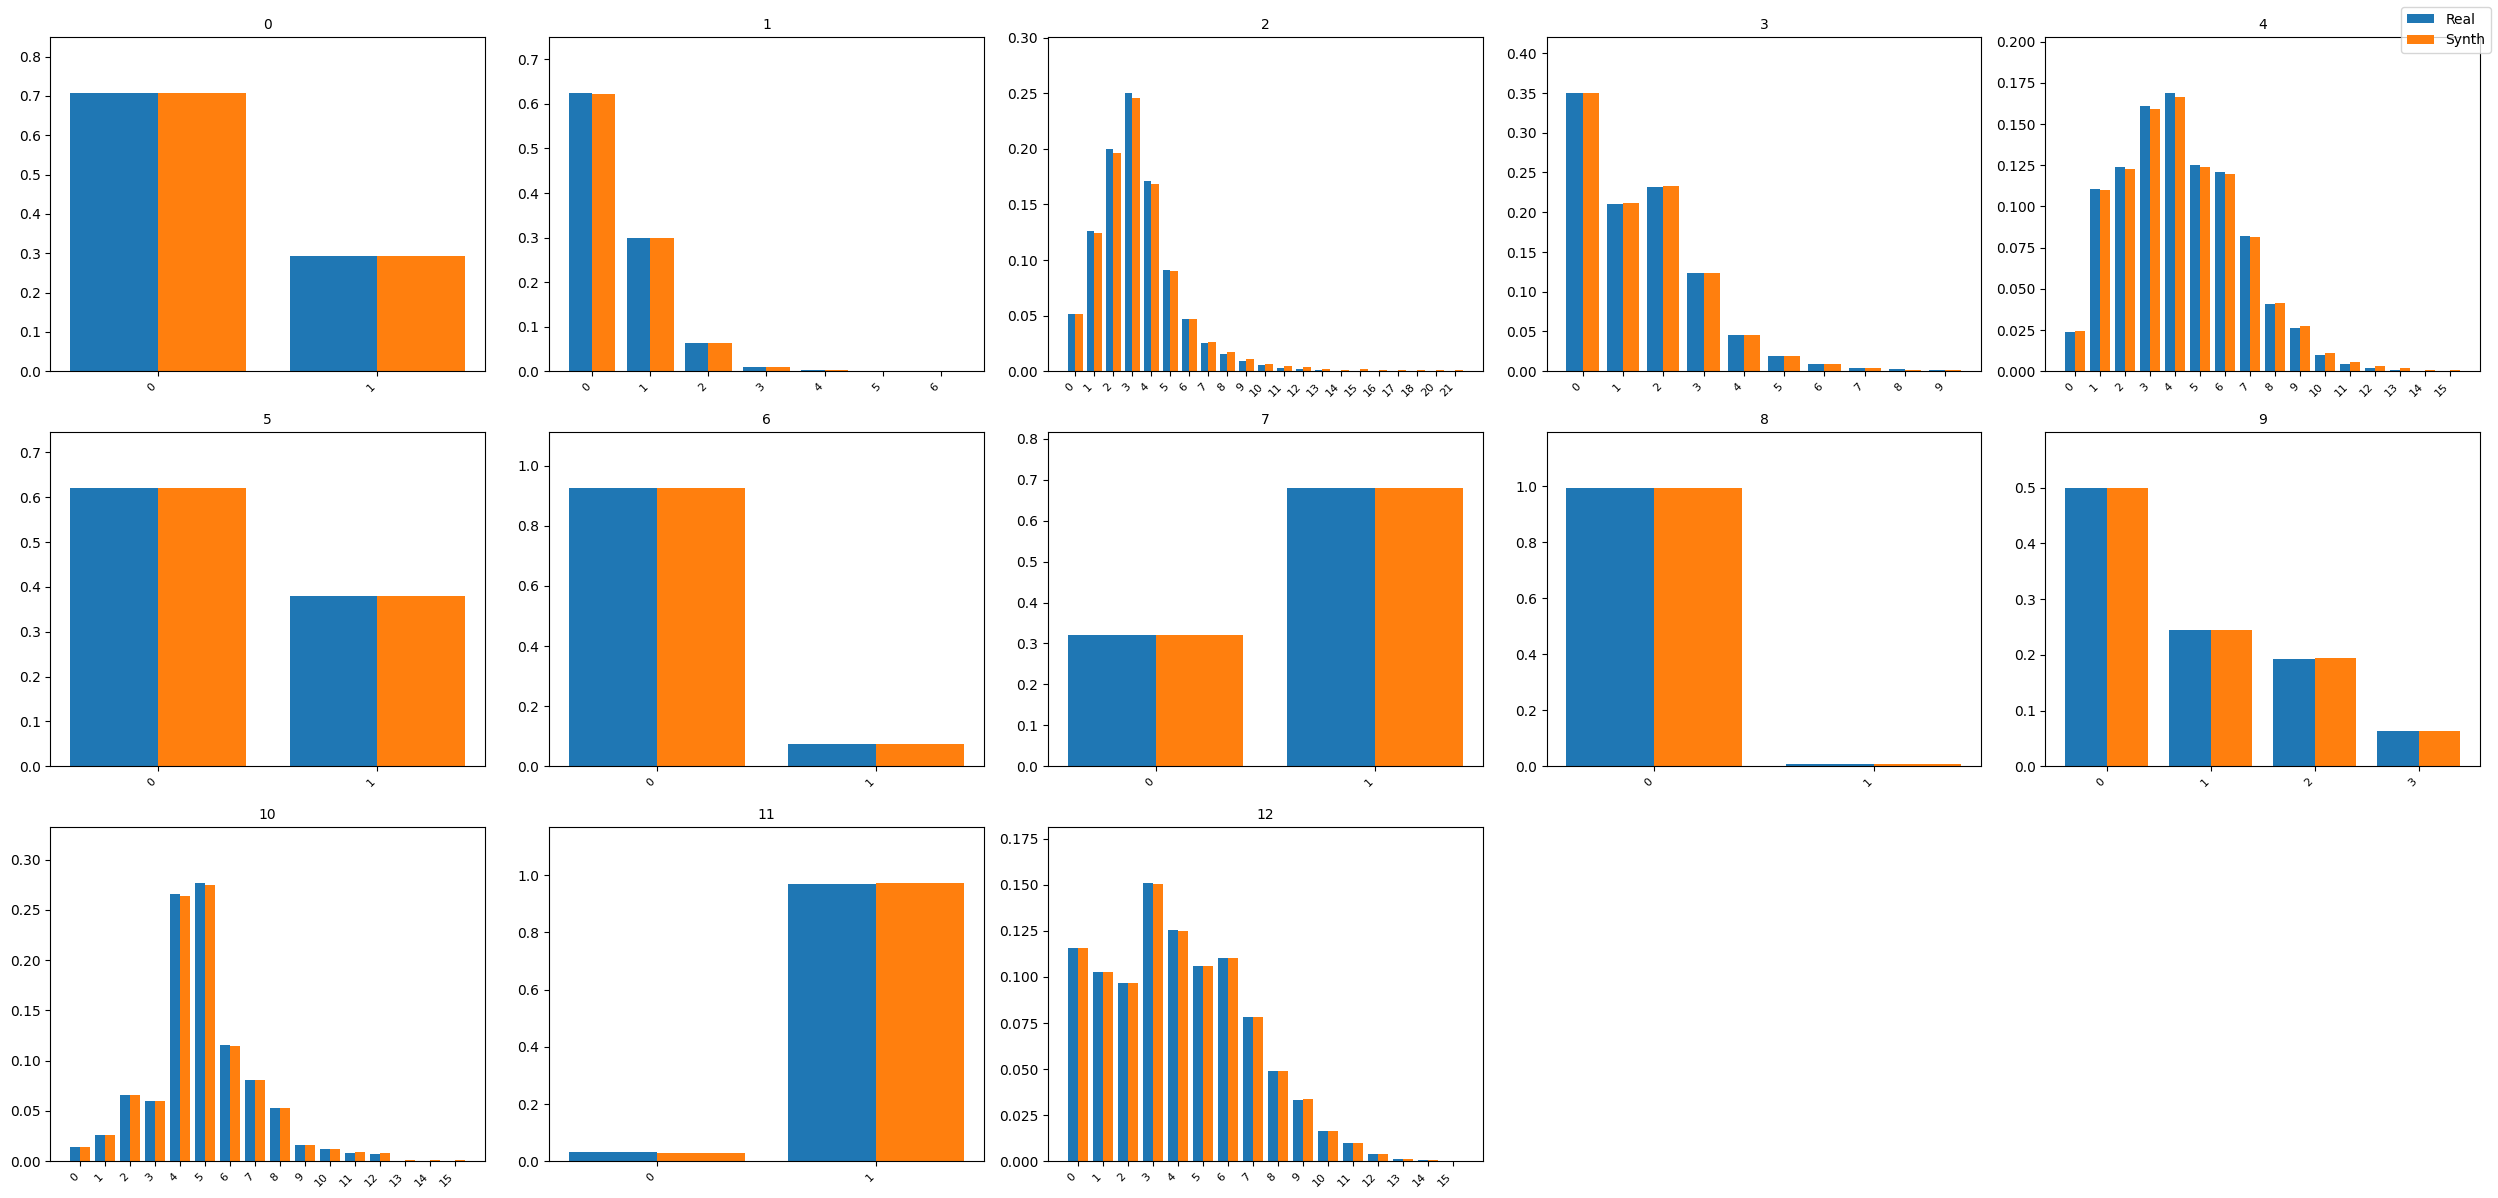

In [12]:
import matplotlib.pyplot as plt
import math

def compare_all_categorical_subplots(df_real, df_synth, class_col=None):
    cols = df_real.columns[:-1] if class_col is None else [c for c in df_real.columns if c != class_col]

    n = len(cols)
    cols_per_row = 5                         # anpassen nach Geschmack
    rows = math.ceil(n / cols_per_row)

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*5, rows*4))
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        # relative Häufigkeiten
        vc_real = df_real[col].value_counts(normalize=True)
        vc_synth = df_synth[col].value_counts(normalize=True)

        all_vals = sorted(set(vc_real.index) | set(vc_synth.index))
        real_vals = [vc_real.get(v, 0) for v in all_vals]
        synth_vals = [vc_synth.get(v, 0) for v in all_vals]

        x = range(len(all_vals))
        width = 0.4

        ax.bar([i - width/2 for i in x], real_vals, width=width, label="Real")
        ax.bar([i + width/2 for i in x], synth_vals, width=width, label="Synth")

        ax.set_title(col, fontsize=10)
        ax.set_xticks(list(x))
        ax.set_xticklabels(all_vals, rotation=45, ha="right", fontsize=8)
        ax.set_ylim(0, max(real_vals + synth_vals) * 1.2)

    # Falls Achsen übrig sind (wenn Grid > Anzahl Features)
    for empty_ax in axes[n:]:
        empty_ax.axis('off')

    # globale Legende
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout()
    plt.show()

compare_all_categorical_subplots(data, synthetic_data)
